In [2]:
import kagglehub

path = kagglehub.dataset_download("ranjansingh001/dataset")

print("Path to dataset files:", path)

100%|██████████| 12.7M/12.7M [00:00<00:00, 107MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ranjansingh001/dataset/versions/1


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

DATA_DIR = os.path.join(path, "MatricesTest2014")
IMAGE_SIZE = (64, 64)
NUM_CHANNELS = 1
TEST_SPLIT = 0.2

images = []
labels = []

class_names = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f"Found {len(class_names)} classes: {class_names}")

for label_index, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = os.listdir(class_path)

    for image_name in image_files:
        img_path = os.path.join(class_path, image_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Skipping unreadable image: {img_path}")
                continue

            img = cv2.resize(img, IMAGE_SIZE)

            images.append(img)
            labels.append(label_index)
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

images = np.array(images, dtype="float32") / 255.0
labels = np.array(labels, dtype="int")

images = np.expand_dims(images, axis=-1)

labels_categorical = to_categorical(labels, num_classes=len(class_names))

print(f"Total images processed: {len(images)}")
print(f"Image shape: {images.shape}")
print(f"Label shape: {labels_categorical.shape}")


X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_categorical, test_size=TEST_SPLIT, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Found 84 classes: ['q', 'operations', 'r', '=', '1', 'z', 'capital_R', '2', 'numbers', 'sum', 'g', 'theta', '6', 'bigBrackClose', 'w', 'bigBrackOpen', 'geq', 'x', '7', 'capital_A', '-', 'capital_S', 'capital_C', 'neq', '9', '+', 's', 'multiply', 'log', 'p', '4', 'k', 'capital_T', '0', 'phi', 'capital_G', 'beta', 'v', 'sin', 'forall', 'infinity', 'capital_N', 'capital_F', 'epsilon', 'tan', '(', 'gamma', 'idots', 'capital_P', 'pm', 'pie', '3', 'lambda', 'capital_K', 'mu', 'leq', 'rightarrorw', 'times', 'b', 'alpha', 'lt', 'capital_M', 'mathsfunctions', 'h', ')', 'delta', 'limit', 'capital_I', 't', '5', 'f', 'capital_H', 'c', 'd', 'i', 'y', '8', 'o', 'gt', 'sigma', 'exists', 'a', 'u', 'capital_B']
Skipping unreadable image: /root/.cache/kagglehub/datasets/ranjansingh001/dataset/versions/1/MatricesTest2014/mathsfunctions/sqrt
Skipping unreadable image: /root/.cache/kagglehub/datasets/ranjansingh001/dataset/versions/1/MatricesTest2014/mathsfunctions/theta
Skipping unreadable image: /root/.c

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
print("✅ Data augmentation setup complete!")

✅ Data augmentation setup complete!


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 84)             │        43,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,496,468 (9.52 MB)

 Trainable params: 2,496,020 (9.52 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2005 - loss: 4.4093
Epoch 1: val_accuracy improved from -inf to 0.03156, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.2023 - loss: 4.3900 - val_accuracy: 0.0316 - val_loss: 16.9283
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5066 - loss: 1.9954
Epoch 2: val_accuracy improved from 0.03156 to 0.09182, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5067 - loss: 1.9949 - val_accuracy: 0.0918 - val_loss: 11.1903
Epoch 3/25
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6095 - loss: 1.5007
Epoch 3: val_accuracy improved from 0.09182 to 0.24390, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6097 - loss: 1.4996 - val_accuracy: 0.2439 - val_loss: 10.6647
Epoch 4/25
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6788 - loss: 1.2074
Epoch 4: val_accuracy improved from 0.243

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"❌ Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 67.48%
❌ Test Loss: 1.9477


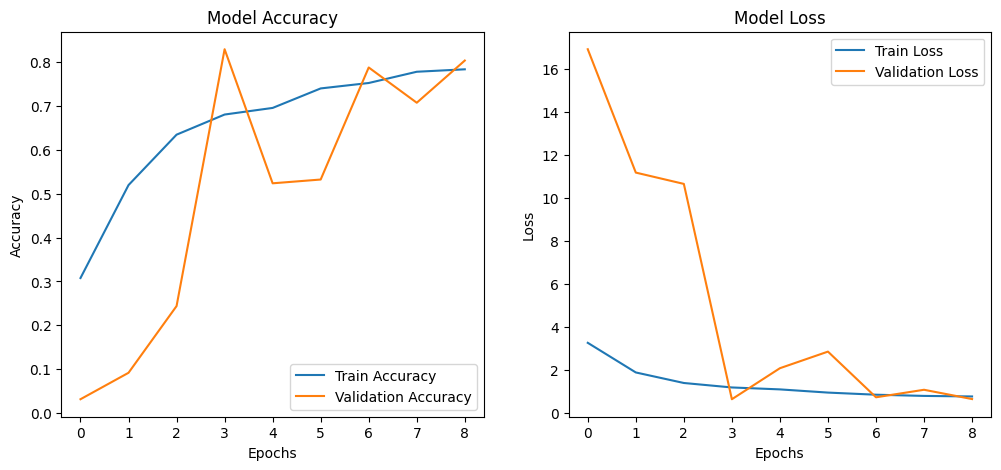

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()